In [1]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

from nltk.tokenize import sent_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer

In [38]:
sessions = np.arange(25, 79)
data=[]

for session in sessions:
    # directory = "./TXT/Session "+str(session)+" - "+str(1945+session)
    directory = f"./TXT/Session {session} - {1945+session}"
    for filename in os.listdir(directory):
        # f = open(os.path.join(directory, filename))
        with open(os.path.join(directory, filename)) as f:
            if filename[0]==".": #ignore hidden files
                continue
            splt = filename.split("_")
            data.append([session, 1945+session, splt[0], f.read()])

df_speech = pd.DataFrame(data, columns=['Session','Year','ISO-alpha3 Code','Speech'])

df_speech.head()

,Session,Year,ISO-alpha3 Code,Speech
0,25,1970,AUT,155.\t May I begin by expressing to Ambassado...
1,25,1970,MEX,"33.\t Mr. President, I take great pleasure in..."
2,25,1970,COG,122.\t I cannot begin my intervention without...
3,25,1970,DZA,1. The delegation of Algeria is very pleased ...
4,25,1970,LKA,"176.\t Mr. President, the delegation of Ceylon..."


In [5]:
file_path = './data/UNSD — Methodology.csv'

df_codes = pd.read_csv(file_path, sep=None, engine='python')

df_codes.head()

,﻿Global Code,Global Name,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name,Country or Area,M49 Code,ISO-alpha2 Code,ISO-alpha3 Code,Least Developed Countries (LDC),Land Locked Developing Countries (LLDC),Small Island Developing States (SIDS)
0,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Algeria,12,DZ,DZA,NaN,NaN,NaN
1,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Egypt,818,EG,EGY,NaN,NaN,NaN
2,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Libya,434,LY,LBY,NaN,NaN,NaN
3,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Morocco,504,MA,MAR,NaN,NaN,NaN
4,1,World,2.0,Africa,15.0,Northern Africa,NaN,NaN,Sudan,729,SD,SDN,x,NaN,NaN


In [6]:
# Merge on ISO-alpha3
df_merged = pd.merge(df_codes, df_speech, left_on="ISO-alpha3 Code", right_on="ISO-alpha3 Code")

# required columns
df_merged = df_merged[["Country or Area", "Region Name", "Sub-region Name", "ISO-alpha3 Code",
                       "Least Developed Countries (LDC)", "Session", "Year", "Speech"]]

In [7]:
def clean_df(df):
    # remove data with null value in year column
    df = df[df['Year'].notnull()]
    
    # remove data with null values in country column
    df = df[df['Country or Area'].notnull()]
    
    # replace null values in 'Least Developed Countries (LDC)' column with ''
    df["Least Developed Countries (LDC)"] = df["Least Developed Countries (LDC)"].fillna('')
    
    df.set_index(["ISO-alpha3 Code", "Year"], inplace=True)
    
    return df

df_merged = clean_df(df_merged)

In [8]:
# leaning of the text, remove unusual symbols from the text, creating new text_clean column
# convert text data to lower case (for easier analysis)
df_merged['Speech_clean'] = df_merged['Speech'].str.lower()

def clean(sentence):    
    # Remove any tags:
    cleaned = re.sub(r"(?s)<.?>", " ", sentence)
    # Keep only regular chars:
    cleaned = re.sub(r"[^A-Za-z0-9(),*!?\'\`]", " ", cleaned)
    # Remove unicode chars
    cleaned = re.sub("\\\\u(.){4}", " ", cleaned)
    return cleaned.strip()

# clean text
df_merged['Speech_clean'] = df_merged.Speech_clean.apply(lambda x: clean(x))

In [9]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /Users/meryjoy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/meryjoy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/meryjoy/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/meryjoy/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [10]:
from nltk.probability import FreqDist
from nltk import word_tokenize

# load text of Austria in 1970
text = df_merged.loc['AUT',1970]["Speech"]

# tokenize words
words = word_tokenize(text)

# compute word frequency
freq = FreqDist(words)

# show 30 most frequent words
freq.most_common(30)

[('the', 383),
 ('of', 268),
 (',', 180),
 ('to', 163),
 ('.', 160),
 ('and', 116),
 ('in', 104),
 ('a', 91),
 ('that', 55),
 ('by', 39),
 ('this', 39),
 ('for', 39),
 ('which', 38),
 ('be', 35),
 ('on', 34),
 ('is', 32),
 ('United', 30),
 ('The', 29),
 ('Nations', 28),
 ('as', 27),
 ('Austria', 26),
 ('our', 23),
 ('with', 23),
 ('I', 22),
 ('international', 22),
 ('it', 22),
 ('has', 21),
 ('States', 21),
 ('all', 20),
 ('its', 20)]

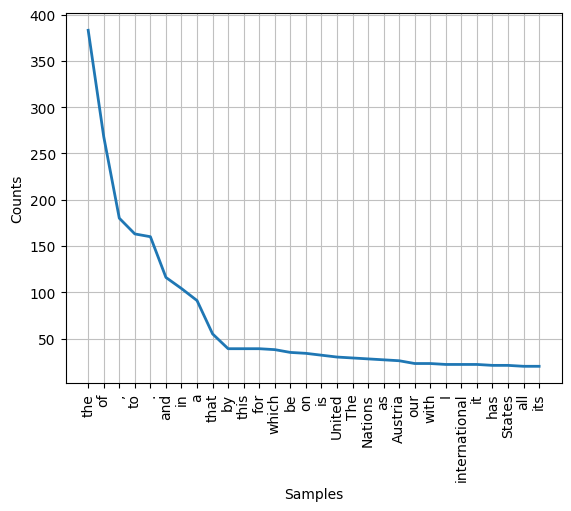

<Axes: xlabel='Samples', ylabel='Counts'>

In [11]:
# plot the histogram with the top most used words
freq.plot(30)

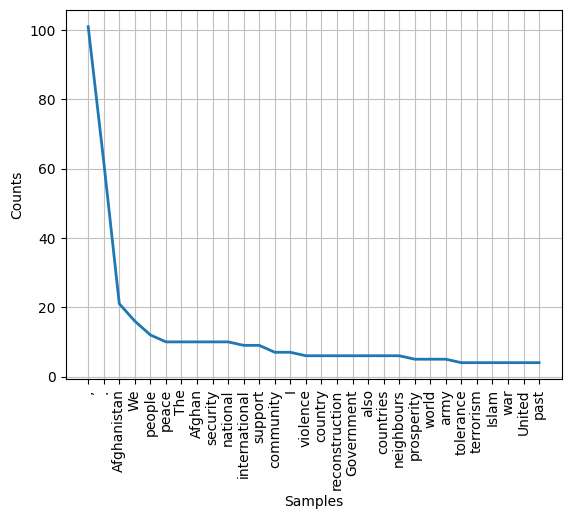

<Axes: xlabel='Samples', ylabel='Counts'>

In [12]:
from nltk.corpus import stopwords

def preprocess(words):
    sw = stopwords.words("english")
    no_sw = []
    for w in words:
        if (w not in sw):
            no_sw.append(w)
    return no_sw

text = df_merged.loc[("AFG", 2002)]["Speech"]

words = word_tokenize(text)
words = preprocess(words)
freq = FreqDist(words)

freq.plot(30)

In [13]:
df_merged = df_merged.sort_index()
df_merged.loc(axis=0)["DEU", 2002:2004]["Speech"]

ISO-alpha3 Code  Year
DEU              2002    ﻿First of all, I\nshould like to wish you ever...
                 2003    ﻿I wish to\nbegin by congratulating the Presid...
                 2004    Let me first\nof all congratulate you, Preside...
Name: Speech, dtype: object

In [14]:
# one approach is to get all the speeches per country in a list or, all together in a single string format 
# in order to feed all the speeches to the functions created for sentiment analysis and tokenisation

# might not be ideal since we do want to make future predictions also based on each country's speech per year

speech_data = df_merged.loc(axis=0)["DEU", 2002:2004]["Speech"]

# Combine each speech with its year and country in the desired format
formatted_speeches = [f"{code}, {year}: {speech}" for (year, code), speech in speech_data.items()]

# Option 1: Return as a list of formatted speeches
speeches_list = formatted_speeches

# Option 2: Concatenate all formatted speeches into a single string
all_speeches = " ".join(formatted_speeches)

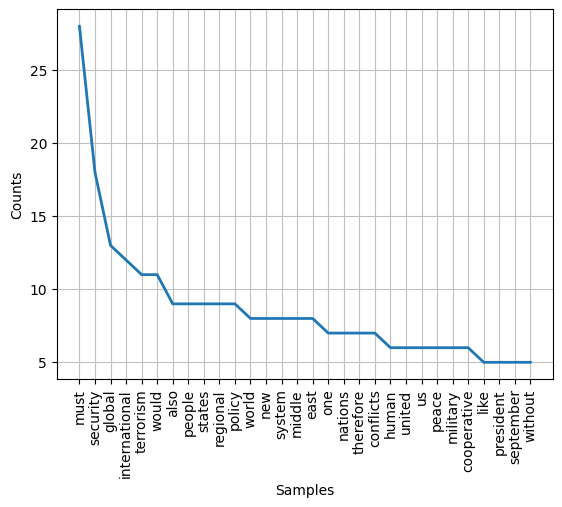

<Axes: xlabel='Samples', ylabel='Counts'>

In [15]:
def preprocess(words):
    sw = stopwords.words("english")
    no_sw = []
    for w in words:
        w = w.lower()
        if (w not in sw) and (w.isalpha()):
            no_sw.append(w)
    return no_sw

text = df_merged.loc(axis=0)["DEU", 2002]["Speech"]
# text = all_speeches

words = word_tokenize(text)
words = preprocess(words)
freq = FreqDist(words)

freq.plot(30)

In [16]:
keywords = [
    'gender equality', 'women education', 'girls education', 'equal access to education', 
    'education for girls', 'gender parity', 'gender balance', 'gender equity',
    'gender discrimination', 'gender gap', 'women\'s rights', 'female education',
    'education for women', 'girls\' schooling', 'women\'s education', 'educational access for girls', 
    'educational equality', 'education', 'gender', 'women', 'parity', 'girls'
]

#keywords = ["gender equality", "education", "gender", 'women', "parity", "girls", "girls' education"]

def process_sentences(speech, keywords):
    """Extract sentences that contain keywords using NLTK's sentence tokenizer."""
    # NLTK sent_tokenize to split the speech into sentences
    sentences = sent_tokenize(speech)
    
    # empty list to store relevant sentences
    relevant_sentences = []
    
    # iterate through each sentence, check for keywords
    for sentence in sentences:
        sentence_lower = sentence.lower()  # Convert to lowercase
        if any(keyword in sentence_lower for keyword in keywords):
            relevant_sentences.append(sentence)  # Append sentence if a keyword is found
            
    return ' '.join(relevant_sentences)

process_sentences((df_merged.loc(axis=0)[("AFG",2002)]["Speech"]), keywords)

"The success of\nthe Loya Jirga, with broad and unprecedented\nparticipation of women, was a significant milestone in\nthe recent history of Afghanistan, and a major step\nforward in the process of peace, stability and nation-\nbuilding. Secondly, as a result of the back-to-school\ncampaign, schools that were closed for over six years,\nwhen neither boys nor girls went to school, have\nreopened. Three million children from all over the\ncountry, both boys and girls, have returned to school. We have already\nestablished a Judicial Commission, to rebuild the\nAfghan justice system, a Civil Service Commission to\nreform the entire administration and impose a merit-\nbased system, as well as a Human Rights Commission\nto protect human rights, women's rights and civil\nliberties."

In [17]:
# Regular expression example
s = set({})
import re
for w in words:
    if re.match('g.*n$', w):
        s.add(w)
print(s)

{'green', 'german', 'gain', 'globalization'}


### New functions ###

We are going to define some new functions that will process the speech in different steps.
* """Preprocess the text by converting to lowercase, removing non-alphabetic words and stopwords."""
* """Extract sentences that contain keywords related to gender equality in education using NLTK's sentence tokenizer."""
* """Count the total occurrences of the keywords in the speech."""
* """Analyze the speeches for keyword occurrences and sentiment analysis for each country and year."""
* """List of years with the highest number of keywords in their speech and years with the most positive sentiment."""

In [19]:
def preprocess(words):
    sw = stopwords.words("english")
    no_sw = []
    for w in words:
        w = w.lower()
        if (w not in sw) and (w.isalpha()):
            no_sw.append(w)
    return no_sw

In [18]:
def process_sentences(speech, keywords):
    """Extract sentences that contain keywords using NLTK's sentence tokenizer."""
    # NLTK sent_tokenize to split the speech into sentences
    sentences = sent_tokenize(speech)
    
    # empty list to store relevant sentences
    relevant_sentences = []
    
    # iterate through each sentence, check for keywords
    for sentence in sentences:
        sentence_lower = sentence.lower()  # Convert to lowercase
        if any(keyword in sentence_lower for keyword in keywords):
            relevant_sentences.append(sentence)  # Append sentence if a keyword is found
            
    return ' '.join(relevant_sentences)

In [20]:
def count_keywords(speech, keywords):
    """Count the total occurrences of the keywords in the speech."""
    #speech_lower = speech.lower()
    keyword_count = 0
    
    for keyword in keywords:
        occurrences = re.findall(keyword, speech)
        keyword_count += len(occurrences)
    
    return keyword_count

#count_keywords(df_merged.loc(axis=0)[("AFG",2002)]["Speech"], keywords)

In [21]:
def analyze_speech(df_merged):
    """Analyze the speeches for keyword occurrences and sentiment analysis for each country and year."""
    sia = SentimentIntensityAnalyzer()
    data = []
    
    for (country_code, year), speech in df_merged['Speech'].items():

        speech = speech.replace('\n', ' ').replace('\t', ' ')
        
        # relevant parts of the speech for sentiment analysis
        relevant_text = process_sentences(speech, keywords)
        
        # sentiment analysis
        if relevant_text:
            sentiment_score = sia.polarity_scores(relevant_text)['pos']
        else:
            sentiment_score = 0
        
        # occurrences of keywords in the entire speech
        keyword_count = count_keywords(speech, keywords)
        
        data.append({
            "ISO-alpha3 Code": country_code,
            "Year": year,
            "Keyword Count": keyword_count,
            "Sentiment Score": sentiment_score,
            "Relevant Text": relevant_text
        })
    df_results = pd.DataFrame(data)
    
    return df_results

In [22]:
df_results = analyze_speech(df_merged)
df_final = df_results.set_index(["ISO-alpha3 Code", "Year"])

In [23]:
df_final.head()

Keyword Count  Sentiment Score  \
ISO-alpha3 Code Year                                   
AFG             1971              0            0.000   
                1972              0            0.000   
                1973              1            0.273   
                1974              0            0.000   
                1975              0            0.000   

                                                          Relevant Text  
ISO-alpha3 Code Year                                                     
AFG             1971                                                     
                1972                                                     
                1973  New and effective steps will be taken for crea...  
                1974                                                     
                1975

In [24]:
def highest_keyword_sentiment(df_results):
    """
    This function returns a DataFrame containing the list of years where each country had
    the highest number of keywords in their speech and the list of years with the most positive sentiment.
    """
    
    data = []
    for country in df_results['ISO-alpha3 Code'].unique():
        country_data = df_results[df_results['ISO-alpha3 Code'] == country]
        
        max_keyword_count = country_data['Keyword Count'].max()
        
        # years with the maximum keyword count
        max_keyword_years = country_data[country_data['Keyword Count'] == max_keyword_count]['Year'].tolist()
        
        # maximum sentiment score
        max_sentiment_score = country_data['Sentiment Score'].max()
        
        # all years with the maximum sentiment score
        max_sentiment_years = country_data[country_data['Sentiment Score'] == max_sentiment_score]['Year'].tolist()
        
        data.append({
            'ISO-alpha3 Code': country,
            'Years with Highest Keyword Count': max_keyword_years,
            'Years with Most Positive Sentiment': max_sentiment_years
        })
    
    df_summary = pd.DataFrame(data)
    
    return df_summary

In [26]:
df_counts = highest_keyword_sentiment(df_results)

#### Save final data into a csv file ####

In [32]:
df_final = pd.merge(df_results, df_counts, left_on="ISO-alpha3 Code", right_on="ISO-alpha3 Code")
df_final = df_final.set_index(["ISO-alpha3 Code", "Year"])
df_final.head(10)
df_final.sample(10)

,,Keyword Count,Sentiment Score,Relevant Text,Years with Highest Keyword Count,Years with Most Positive Sentiment
ISO-alpha3 Code,Year,,,,,
MNG,1984,1,0.115,The Moscow Declaration of the States Members o...,"[2005, 2012]",[1993]
LUX,2022,3,0.165,That partnership goes beyond traditional coope...,[2021],[2009]
BEN,2022,1,0.214,"“At the national level, Benin, among other act...",[2009],[1985]
GRC,1989,1,0.248,I should be remiss if I did not pay a tribute ...,"[1995, 2008]",[2002]
BTN,2019,7,0.204,We are convinced that it is only through quali...,[2019],[2014]
IRN,1993,2,0.103,"In this context, it is most important to take ...",[1998],[1999]
BGR,1998,1,0.273,Bulgaria attaches great importance to the acti...,[2016],[1979]
ATG,1993,1,0.213,As V. C. Bird and his generation pass the mant...,[2007],[2008]
LBR,1994,2,0.150,"This is particularly true for my own country, ...",[2009],[2023]


In [98]:
df_final.to_csv('./data/df_speech_processed.csv', index=True)

## Graphs ##

/var/folders/6f/_m3vtyy92m94t_l4qyl157240000gn/T/ipykernel_37968/1207627656.py:30: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', 10)


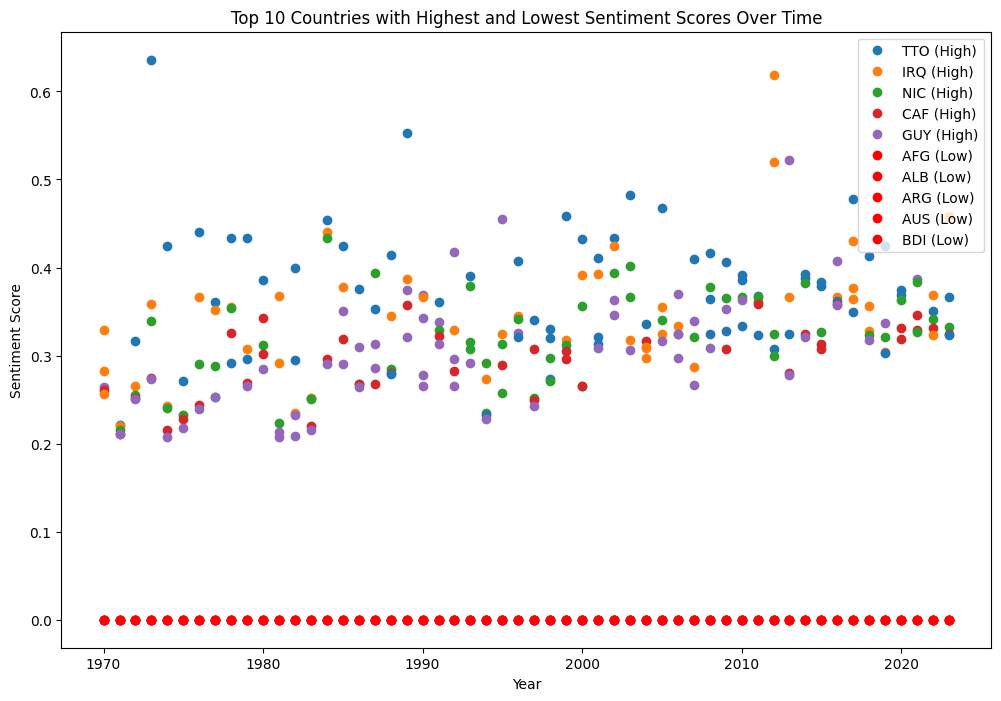

In [27]:
def sentiment_countries(df):
    """
    Find the countries with the highest and lowest average sentiment scores.
    """
    results = {}
    years = df.index.get_level_values('Year').unique()
    
    for year in years:
        # Get the data for the current year
        df_year = df.xs(year, level='Year')
        
        # Get the top N countries with the highest sentiment score for this year
        highest_scores = df_year['Sentiment Score'].nlargest(5).index.tolist()
        
        # Get the top N countries with the lowest sentiment score for this year
        lowest_scores = df_year['Sentiment Score'].nsmallest(5).index.tolist()
        
        # Store the results in a dictionary with the year as the key
        results[year] = (highest_scores, lowest_scores)
    
    return results


def plot_top_sentiment(df):
    """
    Plot sentiment scores over time for the countries with the 
    highest and lowest average sentiment scores.
    """
    top_countries = sentiment_countries(df)
    colors = plt.cm.get_cmap('tab10', 10)
    
    # Keep track of assigned colors for each top highest sentiment country
    color_mapping = {}

    fig, ax = plt.subplots(figsize=(12,8))
    
    # Iterate over each year and plot data for the top N countries
    for year, (top_highest, top_lowest) in top_countries.items():
        
        # Assign unique colors to the top N highest sentiment countries for this year
        for i, country in enumerate(top_highest):
            # Assign a unique color if not already assigned
            if country not in color_mapping:
                color_mapping[country] = colors(i)
            
            country_data = df.loc[(country, year)]
            ax.plot(
                year, country_data['Sentiment Score'], 'o', 
                color=color_mapping[country], 
                label=f'{country} (High)' if year == list(top_countries.keys())[0] else ""
            )
        
        # Plot the top N lowest sentiment countries in red for this year
        for country in top_lowest:
            country_data = df.loc[(country, year)]
            ax.plot(
                year, country_data['Sentiment Score'], 'ro', 
                label=f'{country} (Low)' if year == list(top_countries.keys())[0] else ""
            )
    
    # Customize the plot
    ax.set_xlabel('Year')
    ax.set_ylabel('Sentiment Score')
    ax.legend(loc='best')
    plt.title("Top 10 Countries with Highest and Lowest Sentiment Scores Over Time")
    plt.show()

plot_top_sentiment(df_final)

### Merge final df with the other datasets used ###

In [95]:
# Merge df1 and df2 on 'column1', and df2 and df3 on 'column2'
df_parity_clean = pd.read_csv('/Users/meryjoy/Desktop/masters/fundamentals ds/DSAss1/data/df_parity_clean.csv')
df_parity_clean = df_parity_clean.rename(columns={
    'Value': 'Parity_Value', 'Indicator Code': 'Parity_Indicator_Code'
})
df_parity_clean = df_parity_clean.drop(columns=['Unnamed: 0'])


df_literacy_final = pd.read_csv('/Users/meryjoy/Desktop/masters/fundamentals ds/DSAss1/data/df_literacy_final.csv')
df_literacy_final = df_literacy_final.rename(columns={
    'Indicator Code': 'Literacy_Indicator_Code'
})

df_speech_processed = pd.read_csv('/Users/meryjoy/Desktop/masters/fundamentals ds/DSAss1/data/df_speech_processed.csv')


merged_df = pd.merge(df_parity_clean, df_speech_processed, left_on=['Country Code', 'Year'], right_on=['ISO-alpha3 Code', 'Year'])
merged_df = merged_df.drop(columns=['Country Code'])
clean_dataframe = pd.merge(merged_df, df_literacy_final, left_on='ISO-alpha3 Code', right_on='Country Code')
#clean_dataframe = clean_dataframe.drop(columns=['Country Code'])
clean_dataframe = clean_dataframe.set_index(["ISO-alpha3 Code", "Year"])

In [99]:
clean_dataframe.to_csv('./data/final_merged_dataframe.csv', index=True)